In [1]:
import pandas as pd

import pprint

from matplotlib import pyplot as plt
import matplotlib
plt.style.use('./blog.matplotlibrc')

In [2]:
housing = pd.read_csv('data/FMR_All_1983_2019_rev.csv', encoding='latin-1')
housing = (
    housing
    .loc[lambda df: (
        (df['areaname'] == 'Raleigh, NC MSA')
        & (df['cntyname'] == 'Wake County')
    )]
    [['areaname'] + [i for i in housing if i.startswith('fmr') and i.endswith('_3')]]
    .melt(
        id_vars=['areaname'],
        var_name='year',
        value_name='housing'
    )
    .drop('areaname', axis='columns')
    .assign(year=lambda df: (
        df.year.str.extract(r'fmr(\d{2})_3', expand=False)
        .astype(int)
        .map(lambda x: x + 2000 if x < 50 else x + 1900)
    ))
    .assign(housing = lambda df: (df['housing'] * 12))
    .sort_values('year')
)
housing

,year,housing
35,1983,5520.0
34,1985,5676.0
33,1986,6228.0
32,1987,6372.0
31,1988,6552.0
30,1989,6648.0
29,1990,6792.0
28,1991,6972.0
27,1992,7212.0
26,1993,7404.0


In [3]:
BASE_YEAR = 1996
insurance_deflator = (
    pd.read_excel(
        'data/Table 21 Expenditures, Enrollment and Per Enrollee Estimates of Health Insurance.xlsx',
    )
    .iloc[[0, 23], 1:]
    .T
    .rename(columns={0: 'year', 23: 'deflator'})
    .assign(year=lambda df: df['year'].astype(int))
    .set_index('year')
    ['deflator']
    .reindex(list(range(1985, BASE_YEAR + 1)))
    .fillna(method='bfill')
)
insurance_deflator = (
    insurance_deflator
    .div(insurance_deflator[BASE_YEAR])
    .loc[1985: BASE_YEAR - 1]
)
insurance_deflator

year
1985    0.458400
1986    0.458400
1987    0.458400
1988    0.524423
1989    0.607085
1990    0.697262
1991    0.758991
1992    0.839506
1993    0.887815
1994    0.912507
1995    0.950081
Name: deflator, dtype: float64

In [4]:
insurance = (
    pd.read_csv('data/insurance.csv')
    .set_index('year')
    .rename(columns=lambda x: f'insurance_{x}')
    .reindex(list(range(1985, 2019)))
)
for var in insurance.columns:
    insurance.loc[1985:BASE_YEAR - 1, var] = insurance.loc[BASE_YEAR, var] * insurance_deflator

insurance = (
    insurance
    .astype(float)
    .apply(pd.Series.interpolate)
    .reset_index()
)
insurance

,year,insurance_total,insurance_employee
0,1985,2270.915727,584.460548
1,1986,2270.915727,584.460548
2,1987,2270.915727,584.460548
3,1988,2597.991412,668.639291
4,1989,3007.500805,774.033816
5,1990,3454.238325,889.009662
6,1991,3760.040794,967.713366
7,1992,4158.913580,1070.370370
8,1993,4398.237252,1131.964573
9,1994,4520.558239,1163.446055


In [5]:
transportation = (
    pd.read_excel('data/table_03_17_100219.xlsx', skiprows=1)
    .iloc[0, 1:]    
    .astype(float)
    .mul(15_000)
    .div(100)
    .reset_index()
    .rename(columns={'index': 'year', 0: 'transportation'})
    .assign(year=lambda df: df['year'].astype(int))
)
transportation

,year,transportation
0,1975,2154.0
1,1980,3176.0
2,1985,3484.0
3,1990,4954.0
4,1991,5601.0
5,1992,5824.0
6,1993,5804.0
7,1994,5916.0
8,1995,6185.0
9,1996,6389.0


In [6]:
education = (
    pd.read_excel(
        'data/tabn330.10.xls', 
        skiprows=70,
        names=['year', 'college'],
        usecols='A,O'
    )
    .iloc[:63]
    .dropna()
    .assign(year=lambda df: (
        df['year']
        .str.extract(r'.*-(\d\d).*', expand=False)
        .astype(int)
        .map(lambda x: x + 2000 if x < 50 else x + 1900)
    ))
    .assign(college=lambda df: (
        df['college']
        .div(2)
    ))

)
education

,year,college
0,1964,464.305425
1,1967,524.461151
2,1968,544.294238
3,1969,571.463599
5,1970,618.955297
6,1971,662.956828
7,1972,702.398245
8,1973,776.732200
9,1974,798.021915
11,1975,823.308878


In [7]:
wages = (
    pd.read_excel(
        'data/SeriesReport-20200228095134_66f31b.xlsx',
        skiprows=19,
        usecols='A,F',
        names=['year', 'wages']
    )
)

In [8]:
coti = (
    housing
    .merge(insurance, how='outer')
    .merge(transportation, how='outer')
    .merge(education, how='outer')
    .merge(wages, how='outer')
    .set_index('year')
    .sort_index()
    .apply(pd.Series.interpolate)
    .loc[1985:2018]
)

In [9]:
coti

,housing,insurance_total,insurance_employee,transportation,college,wages
year,,,,,,
1985,5676.0,2270.915727,584.460548,3484.0,1840.761775,443.0
1986,6228.0,2270.915727,584.460548,3778.0,1929.253048,463.0
1987,6372.0,2270.915727,584.460548,4072.0,2068.837776,477.0
1988,6552.0,2597.991412,668.639291,4366.0,2201.552152,487.0
1989,6648.0,3007.500805,774.033816,4660.0,2339.116259,500.0
1990,6792.0,3454.238325,889.009662,4954.0,2487.642424,512.0
1991,6972.0,3760.040794,967.713366,5601.0,2621.292203,523.0
1992,7212.0,4158.913580,1070.370370,5824.0,2846.641506,536.0
1993,7404.0,4398.237252,1131.964573,5804.0,3009.943668,555.0


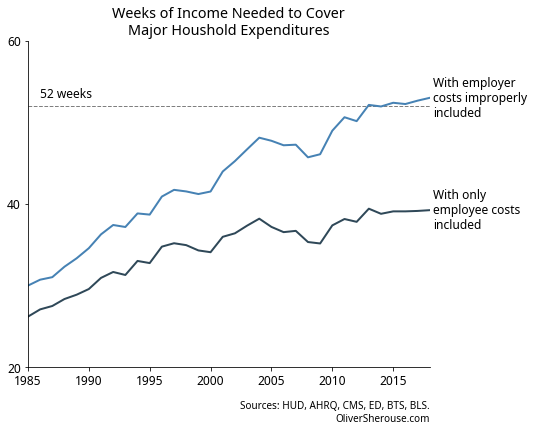

In [10]:
weeks_of_work_total = (
    coti[['housing', 'insurance_total', 'transportation', 'college']]
    .sum(axis='columns')
    .div(coti['wages'])
)
weeks_of_work_employee = (
    coti[['housing', 'insurance_employee', 'transportation', 'college']]
    .sum(axis='columns')
    .div(coti['wages'])
)
fig, ax = plt.subplots()
ax.axhline(52, color='black', ls='--', lw=1, alpha=.5)
ax.text(1986, 53, '52 weeks')

ax.plot(weeks_of_work_total, lw=2)
ax.text(2018.25, weeks_of_work_total[2018], 'With employer\ncosts improperly\nincluded', va='center')
ax.plot(weeks_of_work_employee, lw=2)
ax.text(2018.25, weeks_of_work_employee[2018], 'With only\nemployee costs\nincluded', va='center')

ax.set(
    ybound=(20, 60),
    xbound=(1985, 2018),
    title="Weeks of Income Needed to Cover\nMajor Houshold Expenditures",
    xticks=list(range(1985, 2020, 5)),
    yticks=(20, 40, 60),
)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * .9, pos.height])
fig.text(pos.x0 + pos.width * .9, 0, "Sources: HUD, AHRQ, CMS, ED, BTS, BLS.\nOliverSherouse.com", size='small', ha='right')
fig.savefig('weeks', dpi=300)


In [11]:
pd.DataFrame({
    'employee': weeks_of_work_employee,
    'total': weeks_of_work_total
}).round(2)

,employee,total
year,,
1985,26.15,29.96
1986,27.04,30.68
1987,27.46,30.99
1988,28.31,32.27
1989,28.84,33.31
1990,29.54,34.55
1991,30.90,36.24
1992,31.63,37.39
1993,31.26,37.15


In [12]:
def create_area_chart(coti, insurance, title=''):
    insurance_var = f'insurance_{insurance}'
    toplines = coti[['housing', insurance_var, 'transportation', 'college']].cumsum(axis='columns')
    baselines = toplines.shift(axis='columns').fillna(0)
    fig, ax = plt.subplots()

    for var, topline in toplines.items():
        baseline = baselines[var]
        ax.fill_between(coti.index, baseline, topline)
        ax.text(
            2018.25,
            baseline[2018] + (topline - baseline)[2018] * .5,
            var.split('_')[0].replace('insurance', 'health insurance').title(),
            va='center',
        )

    ax.plot(coti.index, coti['wages'] * 52, color='black', lw=3)
    ax.text(2018.25, coti['wages'][2018] * 52, 'Median Male\nIncome\n(52 Weeks)', va='bottom')

    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set(
        xbound=(1985, 2018),
        xticks=list(range(1985, 2020, 4)),
        ybound=(0, 60000),
        yticks=(0, 20000, 40000, 60000),
        yticklabels=['', '20', '40', '60'],
        ylabel='Current Dollars (thousands)',
        title=title,
    )
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * .9, pos.height])
    fig.text(pos.x0 + pos.width * .9, 0, "Sources: HUD, AHRQ, CMS, ED, BTS, BLS.\nOliverSherouse.com", ha='right')
    fig.savefig(f'expenses_{insurance}_insurance', dpi=300)


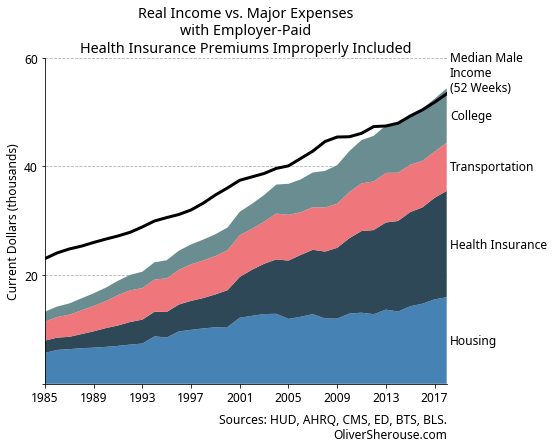

In [13]:
create_area_chart(
    coti,
    'total',
    'Real Income vs. Major Expenses\nwith Employer-Paid\nHealth Insurance Premiums Improperly Included'
)

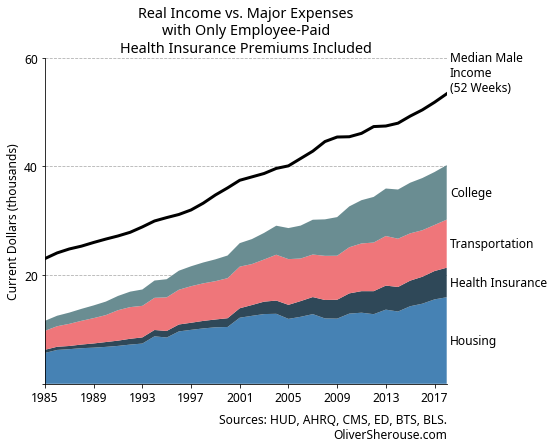

In [14]:
create_area_chart(
    coti,
    'employee',
    'Real Income vs. Major Expenses\nwith Only Employee-Paid\nHealth Insurance Premiums Included'
)